Step 7: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product considering context generation

In [1]:
#fixed graph weights (same click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates
#three user classes

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Environment.Product import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.CG_Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.CG_UCB_Learner import *
import copy

In [3]:
P1 = Product(0,[9,12,13,14.5],[ 1.,  4,  5., 6.5])
P2 = Product(1,[20,22.5,23,24.5],[ 4.,  6.5, 7., 8.5])
P3 = Product(2,[30,31.5,34,34.5],[ 6.,  7.5, 10., 10.5])
P4 = Product(3,[40,42.5,43,46.5],[ 8., 10.5, 11., 14.5])
P5 = Product(4,[50,51.5,53,54.5],[10., 11.5, 13., 14.5])

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = CG_E_commerce()
E.set_lambda(0.5)
for f1 in range(2):
    for f2 in range(2):
        E.set_products(f1,f2,products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

In [4]:
#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms
np.random.seed(1000)

n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1

opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_rewards = np.array([])

mu_c0 = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env = CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learner = Conv_rates(n_arms=n_arms)
    pulled_arm = [[np.zeros(5) for _ in range(2)] for _ in range(2)]

    split1 = 0
    split2 = 0

    for period in range(int(n_days/14)):
        print("period",period)
        for d in range(14):
            if split1==0 and split2==0:
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm[f1][f2] = cr_learner.pull_arm()

                reward = env.round(pulled_arm)  #reward[f1][f2][i]
                cr_learner.update(pulled_arm[0][0] , reward[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

            # FIRST DECISION
            if split1==1 and split2==0:
                pulled_arm = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm[f1][f2] = cr_learners[f1].pull_arm()

                reward = env.round(pulled_arm)

                for f1 in range(2):
                    cr_learners[f1].update(pulled_arm[f1][0], (reward[f1][0]+reward[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1==1 and split2==1:  # we add the second split
                pulled_arm = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward = env.round(pulled_arm)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm[f1][f2], reward[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1 == 0 and split2 ==1:
                pulled_arm = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm[f1][f2] = cr_learners[f2].pull_arm()

                reward = env.round(pulled_arm)

                for f2 in range(2):
                    cr_learners[f2].update(pulled_arm[0][f2], (reward[0][f2]+reward[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))

        # DECISION
        #compute sample probabilities and make decision
        if split1==0 and split2==0:
            mu_c0[split1][split2] = np.sum(np.sum(cr_learner.rewards_per_arm))
            print('mu_c0=',mu_c0)
             # split 1
            collected_rewards=np.concatenate((collected_rewards, cr_learner.collected_rewards)) #axis=None
            #cr_learners = [cr_learner,cr_learner]
            cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            split1 = 1
            split2 = 0

        elif split1==1 and split2==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0[split1][split2] = p_c1*mu_c1 + p_c2*mu_c2
            split2 = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0=',mu_c0)
            collected_rewards=np.concatenate((collected_rewards,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0[0][0]:
                cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]
                split1 = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split1 = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1==1 and split2==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0][0].rewards_per_arm))+np.sum(np.sum(cr_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[0][1].rewards_per_arm))+np.sum(np.sum(cr_learners[1][1].rewards_per_arm))

            mu_c0[split1][split2] = p_c1*mu_c1 + p_c2*mu_c2
            collected_rewards=np.concatenate((collected_rewards,
                                                  cr_learners[0][0].collected_rewards +
                                              cr_learners[0][1].collected_rewards +
                                              cr_learners[1][0].collected_rewards +
                                              cr_learners[1][1].collected_rewards )
                                              ) #axis=None

            print('mu_c0=',mu_c0)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0[1][0]:
                mu_c0[split1][split2] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split2 = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1 == 0 and split2 ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            mu_c0[split1][split2] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0=',mu_c0)
            collected_rewards=np.concatenate((collected_rewards,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0[0][0]:
                mu_c0[split1][split2] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                cr_learners = [Conv_rates(n_arms=n_arms)]
                split2 = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

period 0


C:\Users\rober\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


mu_c0= [[244.516693029193, 0], [0, 0]]
period 1
p_c1*mu_c1 + p_c2*mu_c2= 825.7669963177713
mu_c0= [[244.516693029193, 0], [825.7669963177713, 0]]
--- SPLIT F1 MAKES SENSE ---
period 2
mu_c0= [[244.516693029193, 0], [825.7669963177713, 590.7665690832047]]
p_c1*mu_c1 + p_c2*mu_c2= 590.7665690832047
--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---
period 3
p_c1*mu_c1 + p_c2*mu_c2= 892.3559207438194
mu_c0= [[244.516693029193, 0], [892.3559207438194, 590.7665690832047]]
--- SPLIT F1 MAKES SENSE ---
period 4
mu_c0= [[244.516693029193, 0], [892.3559207438194, 679.0294857817845]]
p_c1*mu_c1 + p_c2*mu_c2= 679.0294857817845
--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---
period 5
p_c1*mu_c1 + p_c2*mu_c2= 871.7099890238683
mu_c0= [[244.516693029193, 0], [871.7099890238683, 679.0294857817845]]
--- SPLIT F1 MAKES SENSE ---
period 6
mu_c0= [[244.516693029193, 0], [871.7099890238683, 630.2397560741155]]
p_c1*mu_c1 + p_c2*mu_c2= 630.2397560741155
--- SPLIT F2 DOESN'T MAKE SENSE (we co

In [5]:
    # CAMBIARE DA QUI
    conversion_rates = [[np.zeros((5,4)) for _ in range(2)] for _ in range(2)]
    np.set_printoptions(suppress=True)

    for f1 in range(2):
        for f2 in range(2):
            for i in range(5):
                conversion_rates[f1][f2][i] = cr_learners[f1][f2].beta_parameters[i][:,0]/(cr_learners[f1][f2].beta_parameters[i][:,0]+cr_learners[f1][f2].beta_parameters[i][:,1])
                opt_vector[f1][f2][e] += np.max(np.array(E.products[f1][f2][i].margins_list) * conversion_rates[f1][f2][i] * cr_learners[f1][f2].lambda_poisson[i])
            conv_rates_per_experiment[f1][f2].append(conversion_rates[f1][f2])

    for f1 in range(2):
        for f2 in range(2):
            mean_units_sold_per_product_per_eperiment[f1][f2].append(cr_learners[f1][f2].lambda_poisson)
            cr_learner_expected_rewards_per_experiment[f1][f2].append(cr_learners[f1][f2].expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


for f1 in range(2):
    for f2 in range(2):
        for i in range(5):
            best_arm_per_product[f1][f2][i] = np.argmax(np.array(E.products[f1][f2][i].margins_list) * np.mean(conv_rates_per_experiment[f1][f2],axis=0)[i]
                                                * np.mean(mean_units_sold_per_product_per_eperiment[f1][f2], axis = 0)[i])#expected_units_sold_per_product[i])#

print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms

IndentationError: expected an indented block after 'for' statement on line 22 (2700140646.py, line 23)

Abbiamo implementato CG LEARNER ENVIRONMENT, PER I LEARNERS usiamo una lista di learners.
RESTA DA IMPLEMENTARE:
1. CAPIRE COME SCRIVERE L'ULTIMA PARTE DEI conversion_rates
2. CONFRONT TS E UCB


## TS AND UCB

In [6]:
#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learner = Conv_rates(n_arms=n_arms)
    ts_learner = TS_poisson(n_arms=n_arms)

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]

    split1_cr = 0
    split2_cr = 0

    split1_ts = 0
    split2_ts = 0

    for period in range(int(n_days/14)):
        print("period",period)
        for d in range(14):
            if split1_cr==0 and split2_cr==0:
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learner.pull_arm()

                reward_cr = env.round(pulled_arm_cr)  #reward_cr[f1][f2][i]
                cr_learner.update(pulled_arm_cr[0][0] , reward_cr[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

            # FIRST DECISION
            if split1_cr==1 and split2_cr==0:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    cr_learners[f1].update(pulled_arm_cr[f1][0], (reward_cr[f1][0]+reward_cr[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_cr==1 and split2_cr==1:  # we add the second split
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_cr == 0 and split2_cr ==1:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f2 in range(2):
                    cr_learners[f2].update(pulled_arm_cr[0][f2], (reward_cr[0][f2]+reward_cr[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))

        # --------------------------------------------------
        # -------------------THOMSON SAMPLING ---------------
        # --------------------------------------------------
        #ciao

            if split1_ts==0 and split2_ts==0:
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                    ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                # FIRST DECISION
            if split1_ts==1 and split2_ts==0:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]+reward_ts[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_ts==1 and split2_ts==1:  # we add the second split
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    for f2 in range(2):
                        ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_ts == 0 and split2_ts ==1:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f2 in range(2):
                    ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))




        # DECISION
        #compute sample probabilities and make decision
        if split1_cr==0 and split2_cr==0:
            mu_c0_cr[split1_cr][split2_cr] = np.sum(np.sum(cr_learner.rewards_per_arm))
            print('mu_c0_cr=',mu_c0_cr)
             # split 1
            collected_reward_crs=np.concatenate((collected_reward_crs, cr_learner.collected_rewards)) #axis=None
            #cr_learners = [cr_learner,cr_learner]
            cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            split1_cr = 1
            split2_cr = 0

        elif split1_cr==1 and split2_cr==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            split2_cr = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]
                split1_cr = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split1_cr = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_cr==1 and split2_cr==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0][0].rewards_per_arm))+np.sum(np.sum(cr_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[0][1].rewards_per_arm))+np.sum(np.sum(cr_learners[1][1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0][0].collected_rewards +
                                              cr_learners[0][1].collected_rewards +
                                              cr_learners[1][0].collected_rewards +
                                              cr_learners[1][1].collected_rewards )
                                              ) #axis=None

            print('mu_c0_cr=',mu_c0_cr)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[1][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_cr == 0 and split2_cr ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                cr_learners = [Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

        
            # DECISION
        #compute sample probabilities and make decision
        if split1_ts==0 and split2_ts==0:
            mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
            print('mu_c0_ts=',mu_c0_ts)
             # split 1
            collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
            #ts_learners = [ts_learner,ts_learner]
            ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
            split1_ts = 1
            split2_ts = 0

        elif split1_ts==1 and split2_ts==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            split2_ts = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                ts_learners = [[TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)] for _ in range(2)]
                split1_ts = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split1_ts = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0][0].collected_rewards +
                                              ts_learners[0][1].collected_rewards +
                                              ts_learners[1][0].collected_rewards +
                                              ts_learners[1][1].collected_rewards )
                                              ) #axis=None


            print('mu_c0_ts=',mu_c0_ts)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[1][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                ts_learners = [TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")



period 0
mu_c0_cr= [[201.23277380037965, 0], [0, 0]]
mu_c0_ts= [[332.7359413368299, 0], [0, 0]]
period 1
p_c1*mu_c1 + p_c2*mu_c2= 823.5445818313018
mu_c0_cr= [[201.23277380037965, 0], [823.5445818313018, 0]]
--- SPLIT F1 MAKES SENSE ---
p_c1*mu_c1 + p_c2*mu_c2= 863.716635561316
mu_c0_ts= [[332.7359413368299, 0], [863.716635561316, 0]]
--- SPLIT F1 MAKES SENSE ---
period 2
mu_c0_cr= [[201.23277380037965, 0], [823.5445818313018, 699.2229435692432]]
p_c1*mu_c1 + p_c2*mu_c2= 699.2229435692432
--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---
mu_c0_ts= [[332.7359413368299, 0], [863.716635561316, 727.7736940472157]]
p_c1*mu_c1 + p_c2*mu_c2= 727.7736940472157
--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---
period 3
p_c1*mu_c1 + p_c2*mu_c2= 797.9764103380377
mu_c0_cr= [[201.23277380037965, 0], [797.9764103380377, 699.2229435692432]]
--- SPLIT F1 MAKES SENSE ---
p_c1*mu_c1 + p_c2*mu_c2= 832.2549014218332
mu_c0_ts= [[332.7359413368299, 0], [832.2549014218332, 727.7736940472157]]


In [ ]:
len(collected_reward_tss)

NameError: name 'opt' is not defined

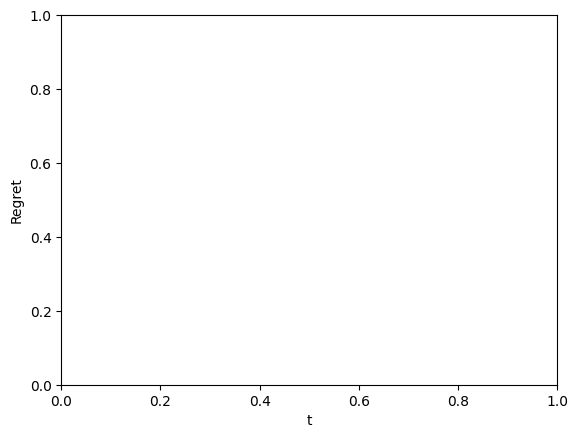

In [7]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.legend(["TS","UCB","Greedy"])
plt.show()

In [ ]:
#print(conv_rates_per_experiment[1][1])
print(conv_rates_per_experiment[1][1])
print(np.mean(conv_rates_per_experiment,axis=0)[1][1])

In [ ]:
print("_______________________________________________")
print("TS Total collected reward")
print(np.sum(np.mean(ts_rewards_per_experiment,axis=0)))
print("UCB Total collected reward")
print(np.sum(np.mean(ucb_rewards_per_experiment,axis=0)))
print("_______________________________________________")

print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("UCB",np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))
print("UCB",np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))

In [ ]:
print("TS Pulls per arm")
for i in range(len(ts_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ts_pulls_per_arm_per_experiment[i])

In [ ]:
print("UCB Pulls per arm")
for i in range(len(ucb_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ucb_pulls_per_arm_per_experiment[i])

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_10, axis=0)), 'r')
ax[0].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_10, axis=0)), 'b')
ax[0].set_title("Cumulative Regret for 10 users")
ax[0].legend(["TS","UCB"])

ax[1].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_100, axis=0)), 'r')
ax[1].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_100, axis=0)), 'b')
ax[1].set_title("Cumulative Regret for 100 users")
ax[1].legend(["TS","UCB"])

ax[2].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_1000, axis=0)), 'r')
ax[2].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_1000, axis=0)), 'b')
ax[2].set_title("Cumulative Regret for 1000 users")
ax[2].legend(["TS","UCB"])

plt.show()

In [ ]:
#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 2
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    for d in range(1000):
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])


    conversion_rates = [[np.zeros((5,4)) for _ in range(2)] for _ in range(2)]
    np.set_printoptions(suppress=True)

    opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]

    for f1 in range(2):
            for f2 in range(2):
                for i in range(5):
                    conversion_rates[f1][f2][i] = cr_learners[f1][f2].beta_parameters[i][:,0]/(cr_learners[f1][f2].beta_parameters[i][:,0]+cr_learners[f1][f2].beta_parameters[i][:,1])
                    opt_vector[f1][f2][e] += np.max(np.array(E.products[f1][f2][i].margins_list) * conversion_rates[f1][f2][i] * cr_learners[f1][f2].lambda_poisson[i])
                conv_rates_per_experiment[f1][f2].append(conversion_rates[f1][f2])

                mean_units_sold_per_product_per_eperiment[f1][f2].append(cr_learners[f1][f2].lambda_poisson)
                cr_learner_expected_rewards_per_experiment[f1][f2].append(cr_learners[f1][f2].expected_rewards)

                

opt = [[0 for _ in range(2)] for _ in range(2)]
for f1 in range(2):
    for f2 in range(2):
        opt[f1][f2] = np.mean(opt_vector[f1][f2]) #+ np.std(opt_vector)


best_arm_per_product = [[np.zeros(5) for i in range(2)] for i in range(2)]
for f1 in range(2):
    for f2 in range(2):

        for i in range(5):   
            best_arm_per_product[f1][f2][i] = np.argmax(np.array(E.products[f1][f2][i].margins_list) * np.mean(conv_rates_per_experiment[f1][f2],axis=0)[i] 
                                                * np.mean(mean_units_sold_per_product_per_eperiment[f1][f2], axis = 0)[i])#expected_units_sold_per_product[i])#

        

In [ ]:
best_arm_per_product, opt

In [ ]:
#THOMPSON REWARD TOTALE

#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    ts_learner = TS_poisson(n_arms=n_arms)


    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    split1_ts = 0
    split2_ts = 0

    for d in range(int(n_days*10/14)):
        for d in range(14):
                
            # --------------------------------------------------
            # -------------------THOMSON SAMPLING ---------------
            # --------------------------------------------------
            #ciao

                if split1_ts==0 and split2_ts==0:
                        for f1 in range(2):
                            for f2 in range(2):
                                pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                        reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                        ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                    # FIRST DECISION
                if split1_ts==1 and split2_ts==0:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f1 in range(2):
                        ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]+reward_ts[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

                elif split1_ts==1 and split2_ts==1:  # we add the second split
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

                elif split1_ts == 0 and split2_ts ==1:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f2 in range(2):
                        ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))


            # DECISION
        if split1_ts==0 and split2_ts==0:
                mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
                print('mu_c0_ts=',mu_c0_ts)
                # split 1
                collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
                #ts_learners = [ts_learner,ts_learner]
                ts_learner1 = copy.deepcopy(ts_learner)
                ts_learner2 = copy.deepcopy(ts_learner)
                ts_learner1.reset()
                ts_learner2.reset()
                ts_learners = [ts_learner1,ts_learner2]
                split1_ts = 1
                split2_ts = 0

        elif split1_ts==1 and split2_ts==0:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[0][1]
                p_c2 = P[1][0] + P[1][1]
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                # we consider the second split
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                split2_ts = 1  # in ogni caso consideremo la seconds feature
                print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None
                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:

                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [[ts_learner1,ts_learner2] for _ in range(2)]
                    split1_ts = 1
                    print("--- SPLIT F1 MAKES SENSE ---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1,ts_learner2]
                    split1_ts = 0
                    print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0][0].collected_rewards +
                                                ts_learners[0][1].collected_rewards +
                                                ts_learners[1][0].collected_rewards +
                                                ts_learners[1][1].collected_rewards )
                                                ) #axis=None


                print('mu_c0_ts=',mu_c0_ts)
                print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[1][0]:
                    ts_learner1.reset()
                    ts_learner2.reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    print("--- SPLIT F2 MAKES SENSE (together with f1)---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learners[0][0])
                    ts_learner2 = copy.deepcopy(ts_learner[1][0])
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1 ,ts_learner2]
                    split2_ts = 0
                    print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

                # we consider the second split
                print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                    ts_learner1.reset()
                    ts_learner2.reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    print("--- SPLIT F2 MAKES SENSE (without f1)---")
                    #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                else:
                    ts_learners = [TS_poisson(n_arms=n_arms)]
                    split2_ts = 0
                    print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

    

In [ ]:
OPT = opt[0][0] * 0.3 + opt[1][0]*0.4 + 0.3*opt[1][1]

In [ ]:
plt.plot(np.cumsum(OPT - collected_rewards, axis=0), 'r')

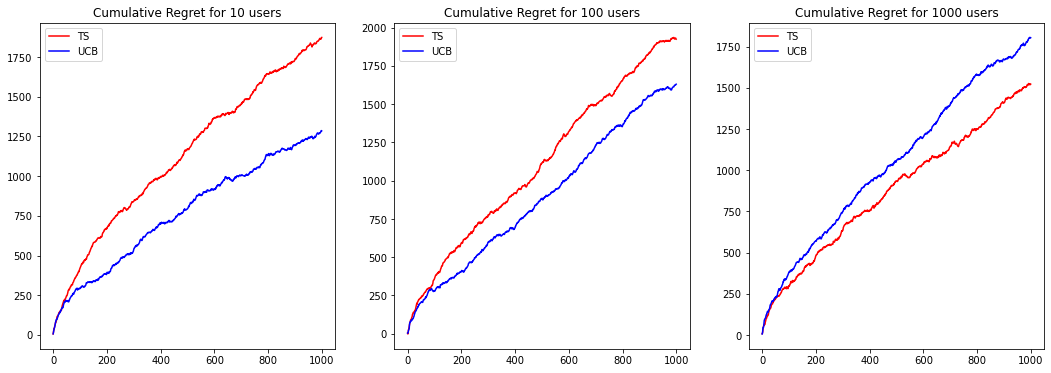

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_10, axis=0)), 'r')
ax[0].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_10, axis=0)), 'b')
ax[0].set_title("Cumulative Regret for 10 users")
ax[0].legend(["TS","UCB"])

ax[1].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_100, axis=0)), 'r')
ax[1].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_100, axis=0)), 'b')
ax[1].set_title("Cumulative Regret for 100 users")
ax[1].legend(["TS","UCB"])

ax[2].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_1000, axis=0)), 'r')
ax[2].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_1000, axis=0)), 'b')
ax[2].set_title("Cumulative Regret for 1000 users")
ax[2].legend(["TS","UCB"])

plt.show()

In [54]:
#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 2
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    for d in range(1000):
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])


    conversion_rates = [[np.zeros((5,4)) for _ in range(2)] for _ in range(2)]
    np.set_printoptions(suppress=True)

    opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]

    for f1 in range(2):
            for f2 in range(2):
                for i in range(5):
                    conversion_rates[f1][f2][i] = cr_learners[f1][f2].beta_parameters[i][:,0]/(cr_learners[f1][f2].beta_parameters[i][:,0]+cr_learners[f1][f2].beta_parameters[i][:,1])
                    opt_vector[f1][f2][e] += np.max(np.array(E.products[f1][f2][i].margins_list) * conversion_rates[f1][f2][i] * cr_learners[f1][f2].lambda_poisson[i])
                conv_rates_per_experiment[f1][f2].append(conversion_rates[f1][f2])

                mean_units_sold_per_product_per_eperiment[f1][f2].append(cr_learners[f1][f2].lambda_poisson)
                cr_learner_expected_rewards_per_experiment[f1][f2].append(cr_learners[f1][f2].expected_rewards)

                

opt = [[0 for _ in range(2)] for _ in range(2)]
for f1 in range(2):
    for f2 in range(2):
        opt[f1][f2] = np.mean(opt_vector[f1][f2]) #+ np.std(opt_vector)


best_arm_per_product = [[np.zeros(5) for i in range(2)] for i in range(2)]
for f1 in range(2):
    for f2 in range(2):

        for i in range(5):   
            best_arm_per_product[f1][f2][i] = np.argmax(np.array(E.products[f1][f2][i].margins_list) * np.mean(conv_rates_per_experiment[f1][f2],axis=0)[i] 
                                                * np.mean(mean_units_sold_per_product_per_eperiment[f1][f2], axis = 0)[i])#expected_units_sold_per_product[i])#

        

In [55]:
best_arm_per_product, opt

([[array([3., 3., 3., 3., 3.]), array([0., 0., 0., 0., 0.])],
  [array([3., 3., 3., 3., 3.]), array([3., 2., 2., 2., 2.])]],
 [[16.774828714951223, 0.0], [20.92478302740907, 38.3003263335101]])

In [68]:
#THOMPSON REWARD TOTALE

#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    ts_learner = TS_poisson(n_arms=n_arms)


    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    split1_ts = 0
    split2_ts = 0

    for d in range(int(n_days*10/14)):
        for d in range(14):
                
            # --------------------------------------------------
            # -------------------THOMSON SAMPLING ---------------
            # --------------------------------------------------
            #ciao

                if split1_ts==0 and split2_ts==0:
                        for f1 in range(2):
                            for f2 in range(2):
                                pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                        reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                        ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                    # FIRST DECISION
                if split1_ts==1 and split2_ts==0:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f1 in range(2):
                        ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]+reward_ts[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

                elif split1_ts==1 and split2_ts==1:  # we add the second split
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

                elif split1_ts == 0 and split2_ts ==1:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f2 in range(2):
                        ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))


            # DECISION
        if split1_ts==0 and split2_ts==0:
                mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
                print('mu_c0_ts=',mu_c0_ts)
                # split 1
                collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
                #ts_learners = [ts_learner,ts_learner]
                ts_learner1 = copy.deepcopy(ts_learner)
                ts_learner2 = copy.deepcopy(ts_learner)
                ts_learner1.reset()
                ts_learner2.reset()
                ts_learners = [ts_learner1,ts_learner2]
                split1_ts = 1
                split2_ts = 0

        elif split1_ts==1 and split2_ts==0:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[0][1]
                p_c2 = P[1][0] + P[1][1]
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                # we consider the second split
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                split2_ts = 1  # in ogni caso consideremo la seconds feature
                print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None
                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:

                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [[ts_learner1,ts_learner2] for _ in range(2)]
                    split1_ts = 1
                    print("--- SPLIT F1 MAKES SENSE ---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1,ts_learner2]
                    split1_ts = 0
                    print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0][0].collected_rewards +
                                                ts_learners[0][1].collected_rewards +
                                                ts_learners[1][0].collected_rewards +
                                                ts_learners[1][1].collected_rewards )
                                                ) #axis=None


                print('mu_c0_ts=',mu_c0_ts)
                print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[1][0]:
                    ts_learner1.reset()
                    ts_learner2.reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    print("--- SPLIT F2 MAKES SENSE (together with f1)---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learners[0][0])
                    ts_learner2 = copy.deepcopy(ts_learner[1][0])
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1 ,ts_learner2]
                    split2_ts = 0
                    print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

                # we consider the second split
                print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                    ts_learner1.reset()
                    ts_learner2.reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    print("--- SPLIT F2 MAKES SENSE (without f1)---")
                    #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                else:
                    ts_learners = [TS_poisson(n_arms=n_arms)]
                    split2_ts = 0
                    print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

    

mu_c0_ts= [[316.2592141078264, 0], [0, 0]]
p_c1*mu_c1 + p_c2*mu_c2= 1033.339297077012
mu_c0_ts= [[316.2592141078264, 0], [1033.339297077012, 0]]
--- SPLIT F1 MAKES SENSE ---
mu_c0_ts= [[316.2592141078264, 0], [1033.339297077012, 1484.7015864766377]]
p_c1*mu_c1 + p_c2*mu_c2= 1484.7015864766377
--- SPLIT F2 MAKES SENSE (together with f1)---
mu_c0_ts= [[316.2592141078264, 0], [1033.339297077012, 1477.3927871315564]]
p_c1*mu_c1 + p_c2*mu_c2= 1477.3927871315564
--- SPLIT F2 MAKES SENSE (together with f1)---
mu_c0_ts= [[316.2592141078264, 0], [1033.339297077012, 1380.8894074240866]]
p_c1*mu_c1 + p_c2*mu_c2= 1380.8894074240866
--- SPLIT F2 MAKES SENSE (together with f1)---
mu_c0_ts= [[316.2592141078264, 0], [1033.339297077012, 1629.614240345667]]
p_c1*mu_c1 + p_c2*mu_c2= 1629.614240345667
--- SPLIT F2 MAKES SENSE (together with f1)---
mu_c0_ts= [[316.2592141078264, 0], [1033.339297077012, 1487.8424625054367]]
p_c1*mu_c1 + p_c2*mu_c2= 1487.8424625054367
--- SPLIT F2 MAKES SENSE (together with 

In [86]:
OPT = opt[0][0] * 0.3 + opt[1][0]*0.4 + 0.3*opt[1][1]

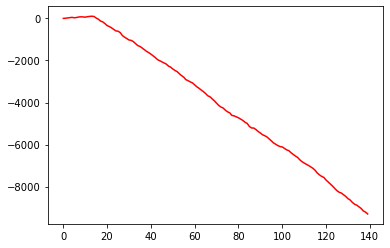

In [91]:
plt.plot(np.cumsum(OPT - collected_rewards, axis=0), 'r')